# Volume 4: Optimal Control as Boundary Value Problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.integrate import solve_bvp

## Problem 1
Given the following cost functional and boundary conditions, solve for and plot the optimal path and acceleration.
\begin{align*}
    J(u) &= \int_0^{30} x^2 + \frac{2\pi}{5}u^2dt \\
    s(t) &= \begin{bmatrix}x(t)\\x'(t) \end{bmatrix}, s(0) = \begin{bmatrix}0\\1 \end{bmatrix}, \quad s(30) = \begin{bmatrix}16\\10 \end{bmatrix}
\end{align*}
Plot your solutions for the optimal $x(t)$ and $u(t)$.

Now we will assume the case that $x''(t) = u(t)$.
That is $u(t)$ is the acceleration of the car. 
Now the Hamiltonian in this case is 

\begin{align}
H(t; x, u, p) &= \begin{bmatrix} p_1 & p_2 \end{bmatrix} \boldsymbol{f}(t; x, x', u) - x^2 - \frac{2\pi u^2}5\\
&= p_1(t) x'(t) + p_2(t) u(t) - x^2(t) - \frac{2\pi u^2(t)}5
\end{align}

Now from Pontryagin's maximum principle we have that 

\begin{align}
p_1'(t) &= \frac{-DH}{Dx} = 2x(t)\\
p_2'(t) &= \frac{-DH}{Dx'} = -p_1(t)
\end{align}

Also we know that $u$ optimizes the Hamiltonian so that 

\begin{align}
H_u &= 0 = p_2(t) - \frac{4\pi u(t)}5\\
&\implies p_2(t) = \frac{4\pi u(t)}5\\
&\implies p_2'(t) = \frac{4\pi u'(t)}5
\end{align}

So our costate equations turn into

\begin{align}
p_1'(t) &= \frac{-DH}{Dx} = 2x(t)\\
u'(t) &= \frac{-5 p_1(t)}{4\pi}
\end{align}

So that our state equation turns into

\begin{align}
&x'(t) = x'(t)\\
&x''(t) = u(t)
\end{align}

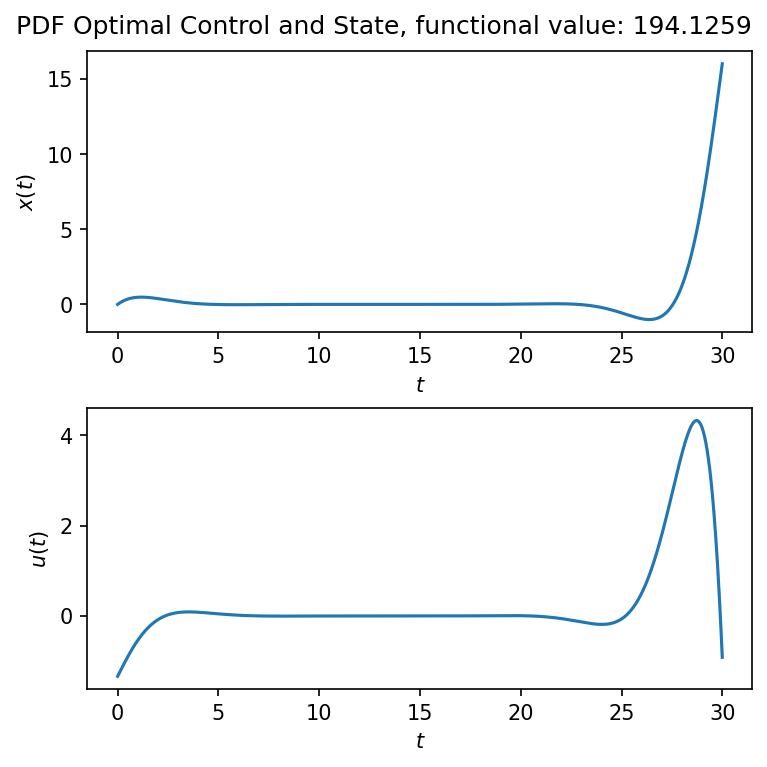

In [2]:
def prob1(t0, tf, dt=0.001):
    """
    Find the optimal path for the fixed time horizon problem
    """
    # define the ODE
    def ode(t, y):
        return np.array([y[1], y[2], -5*y[3] / (4*np.pi), 2*y[0]])

    # defines BC function
    def bc(ya, yb):
        return np.array([ya[0] - 0 , ya[1] - 1, yb[0] - 16, yb[1] - 10])

    t = np.arange(t0, tf, dt)
    y0 = np.ones((4, t.size))

    # solve
    sol = solve_bvp(ode, bc, t, y0)
    integrand1 = sol.y[0]**2 + 2*np.pi*sol.y[2]**2/5

    # plot
    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(5, 5))
    fig.set_dpi(150)
    ax = axs[0]
    ax.plot(t, sol.y[0])
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$x(t)$')

    ax = axs[1]
    ax.plot(t, sol.y[2])
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$u(t)$')
    plt.suptitle(r'PDF Optimal Control and State, functional value: ' + str(round(simpson(integrand1, t), 4)))
    plt.show()

    return

prob1(0, 30)

## Problem 2 
Using the ODEs found in 14.7 and 14.11, the obstacle function 14.8, and the following boundary conditions and parameters solve for and plot the optimal path.
\begin{align*}
    t_0 = 0 &, \quad t_f = 20\\
    (c_x,c_y) &= (4,1)\\
    (r_x,r_y) &= (5,.5)\\
    \lambda &= 20\\
    s_0 = \begin{bmatrix}6\\1.5\\0\\0 \end{bmatrix}&, \quad s_f = \begin{bmatrix}0\\0\\0\\0 \end{bmatrix}
\end{align*}
You will need to choose a $W_1$ and $W_2$ which allow the solver to find a valid path.
If these parameters are not chosen correctly, the solver may find a path which goes through the obstacle, not around it.
Plot the obstacle using plt.contour() to be certain path doesn't pass through the obstacle.
From the p.d.f. we have the state equation

\begin{align}
\dot{s}_1(t) &= s_3(t)\\
\dot{s}_2(t) &= s_4(t)\\
\dot{s}_3(t) &= u_1(t)\\
\dot{s}_4(t) &= u_2(t)
\end{align}

and the costate equations

\begin{align}
\dot{p}_1(t) &= C_x(x, y)\\
\dot{p}_2(t) &= C_y(x, y)\\
\dot{p}_3(t) &= -p_1(t)\\
\dot{p}_4(t) &= -p_2(t)\\
\end{align}

additionally from the maximum principle we have that

\begin{align}
    u_1(t) = \frac{1}{2W_2}p_3(t) \implies \dot{u}_1(t) = \frac{1}{2W_2}\dot{p}_3(t)\\
    u_2(t) = \frac{1}{2W_2}p_4(t) \implies \dot{u}_2(t) = \frac{1}{2W_2}\dot{p}_4(t)\\
\end{align}

This allows us to rewrite the state equations as

\begin{align}
\dot{u}_1(t) &= \frac{-p_1(t)}{2W_2}\\
\dot{u}_2(t) &= \frac{-p_2(t)}{2W_2}\\
\dot{p}_1(t) &= C_x(x, y)\\
\dot{p}_2(t) &= C_y(x, y)\\
\end{align}

We can now use these 4 equations plus the 4 state equations to solve the desired problem.

In [3]:
def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''
    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

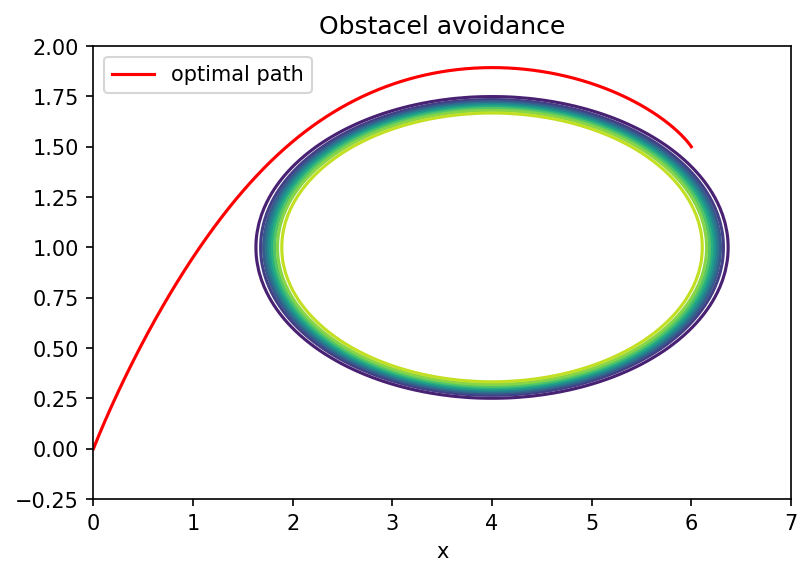

In [4]:
def prob2(W1, W2):
    '''
    Find the optimal path for the fixed time horizon problem
    '''

    c = (4, 1)
    r = (5, 0.5)
    # define the ode system using the equations above
    def ode(t,  y):
        diffeq = np.array([y[2], y[3], y[4], y[5], -y[6]/(2*W2), -y[7]/(2*W2), 
                            obstacle_dx(y[0], y[1], W1=W1, r=r, c=c), obstacle_dy(y[0], y[1], W1=W1, r=r, c=c)])
        return diffeq

    # defines boundary condition function
    def bc(ya,  yb):
        IC = np.array([ya[0]-6, ya[1]-1.5, ya[2]-0, ya[3]-0])
        EC = np.array([yb[0]-0, yb[1]-0, yb[2]-0, yb[3]-0])
        return np.concatenate((IC, EC))

    # solve the system
    dt = 0.01
    t0, tf = 0, 20
    t = np.arange(t0, tf, dt)
    y0 = np.ones((8, t.size))
    sol = solve_bvp(ode, bc, t, y0, max_nodes=30000)

    # plot the obstacle and optimal path
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    t1 = np.linspace(1.5, 6.5, 200)
    t2 = np.linspace(0.25, 1.75, 200)
    T1, T2 = np.meshgrid(t1, t2)
    Z = obstacle(T1, T2, W1=W1, r=r, c=c)
    ax.plot(sol.y[0], sol.y[1], 'r-', label='optimal path')
    ax.contour(T1, T2, Z, 10, cmap='viridis')
    ax.set_title('Obstacel avoidance')
    ax.legend(loc='best')
    ax.set_xlabel('x')
    ax.set_xlim([0, 7])
    ax.set_ylim([-0.25, 2])
    plt.show()

    return

prob2(1.1, 4.2)

## Problem 3
Solve the following boundary value problem:
\begin{align*}
    y'' + 3y &= \sin(t)\\
    y(0) = 0,\quad y(t_f) = &\frac{\pi}{2}, \quad y'(t_f) = \frac{1}{2}\left(\sqrt{3}\pi \cot(\pi\sqrt{75}) - 1 \right).
\end{align*}
Plot your solution. What $t_f$ did the solver find?
Let $y_1 = y$ and $y_2 = y_1'$ then we have the following system

\begin{align}
\begin{bmatrix}
y_1\\y_2
\end{bmatrix}'
&=
\begin{bmatrix}
y_2 \\ \sin(t) - 3y_1
\end{bmatrix}
\end{align}

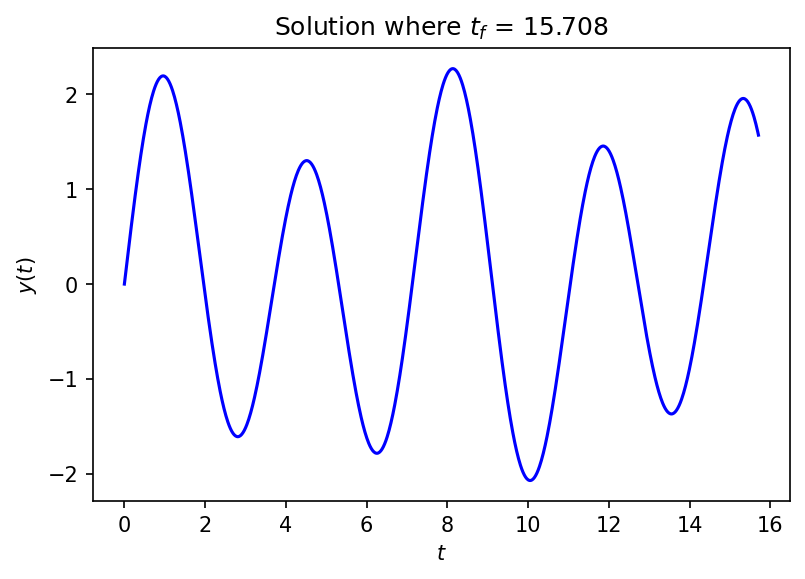

In [5]:
def prob3():
    '''
    Solve the free time horizon BVP.
    Plot the solution and return the correct end time
    '''
    # define ode system
    def ode(t, y, p):
        return p[0] * np.array([y[1], np.sin(p[0]*t) - 3*y[0]])

    # defines boundary conditions
    def bc(ya, yb, p):
        return np.array([ya[0], yb[0]-(np.pi/2), yb[1] - (np.sqrt(3)*np.pi/np.tan(np.pi*np.sqrt(75)) - 1)/2])

    # set up and solve problem
    t_steps = 1000
    t = np.linspace(0, 1, t_steps)
    y0 = np.ones((2, t_steps))
    p0 = np.array([5*np.pi])
    sol = solve_bvp(ode, bc, t, y0, p0)

    # now we plot
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(sol.p[0]*t, sol.sol(t)[0], 'b-')
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(r'Solution where $t_f$ = ' + str(np.round(sol.p[0]*t[-1], 4)))
    plt.show()

    return

prob3()

## Problem 4
Refactor your code from problem 2 to create a free end time BVP and use a new boundary value derived from 14.14.
Plot the solution you found.
What is the optimal time?
Recall from before that we have

\begin{align}
H &= p_1 s_3 + p_2s_4 + p_3u_1 + p_4 u_2 - (1 + C(s1, s2) + W_2|u(t)|^2)
\end{align}

Remember we also have

\begin{align}
    u_1(t) = \frac{1}{2W_2}p_3(t) \implies p_3(t) = 2W_2 u_1(t) \\
    u_2(t) = \frac{1}{2W_2}p_4(t) \implies p_4(t) = 2W_2 u_2(t)\\
\end{align}

So that

\begin{align}
H &= p_1 s_3 + p_2 s_4 + 2W_2u_1^2 + 2W_2 u_2^2 -(1 + C(s1, s2) + W_2|u(t)|^2) 
\end{align}

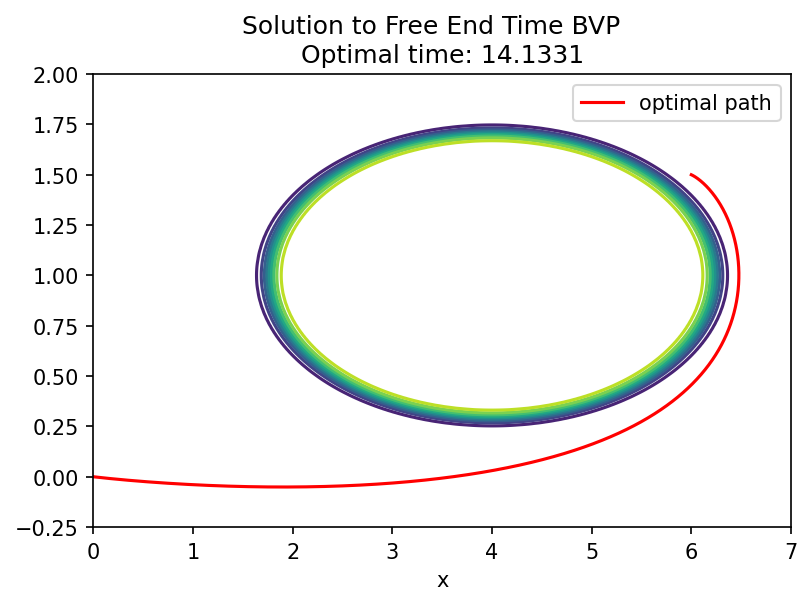

In [6]:
def prob4(W1, W2):
    '''
    Find the optimal path and time for the free time horizon problem.
    Plot the solution and return the optimal time.
    '''

    c = (4, 1)
    r = (5, 0.5)
    # define the ode system using the equations above
    def ode(t,  y, p):
        diffeq = np.array([y[2], y[3], y[4], y[5], -y[6]/(2*W2), -y[7]/(2*W2), 
                            obstacle_dx(y[0], y[1], W1=W1, r=r, c=c), obstacle_dy(y[0], y[1], W1=W1, r=r, c=c)])
        return p[0]*diffeq

    # defines boundary condition function
    def bc(ya,  yb, p):

        IC = np.array([ya[0]-6, ya[1]-1.5, ya[2]-0, ya[3]-0])
        EC = np.array([yb[0]-0, yb[1]-0, yb[2]-0, yb[3]-0])
        u = np.array([yb[4], yb[5]])
        H = np.array([yb[6]*yb[2] + 2*W2*yb[4]**2 + 2*W2*yb[5]**2 - (1 + obstacle(yb[0], yb[1], W1=W1, r =r, c=c ) + W2*np.inner(u, u))])
        return np.concatenate((IC, EC, H))

    # solve the system
    dt = 0.01
    t = np.arange(0, 1, dt)
    y0 = np.ones((8, t.size))
    p0 = np.array([6])
    sol = solve_bvp(ode, bc, t, y0, p0, max_nodes=30000)

    # plot the obstacle and optimal path
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    t1 = np.linspace(1.5, 6.5, 200)
    t2 = np.linspace(0.25, 1.75, 200)
    T1, T2 = np.meshgrid(t1, t2)
    Z = obstacle(T1, T2, W1=W1, r=r, c=c)
    ax.plot(sol.y[0], sol.y[1], 'r-', label='optimal path')
    ax.contour(T1, T2, Z, 10, cmap='viridis')
    ax.legend(loc='best')
    plt.suptitle('Solution to Free End Time BVP')
    ax.set_title('\nOptimal time: ' + str(np.round(sol.p[0], 4)))
    ax.set_xlabel('x')
    ax.set_xlim([0, 7])
    ax.set_ylim([-0.25, 2])
    plt.show()

    return

prob4(10, 9)